In [89]:
import numpy as np
import pandas as pd
import dask.dataframe as dd
from dask import dataframe as dd 
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
sns.set_style("whitegrid")
from pprint import pprint
import sqlite3
import yaml
import re
from datetime import datetime
from datetime import timezone
import maya
from collections import Counter
from glob import glob
import ast
import sys
import json
import cProfile
import time
from collections import OrderedDict
from sklearn.preprocessing import StandardScaler
from scipy import spatial

try: # for pip >= 10
    from pip._internal.req import parse_requirements
except ImportError: # for pip <= 9.0.3
    from pip.req import parse_requirements

from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib_venn import venn3, venn3_circles
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
from sklearn.decomposition import PCA

import networkx as nx
import networkx.algorithms.community as nxcom

import bokeh.io
from bokeh.io import output_file, show
from bokeh.resources import INLINE
from bokeh.models import (BoxSelectTool, Circle, EdgesAndLinkedNodes, HoverTool,
                          MultiLine, NodesAndLinkedEdges, Plot, Range1d, TapTool,
                         BoxZoomTool, ResetTool, OpenURL, CustomJS, Column, SaveTool)
from bokeh.palettes import Spectral4
from bokeh.plotting import figure, output_notebook
from bokeh.models.graphs import from_networkx
from bokeh.models import TextInput, Button

from scipy.spatial.distance import cosine

%matplotlib inline

# Code for hiding seaborn warnings
import warnings
warnings.filterwarnings("ignore")

## Easier navigation:

------------------------------------

### 1. <a href='#setup'>Setup</a>
### 2. <a href='#func'>Supporting Functions</a>
------------------------------------

## Models: 
### 3. <a href='#naive'>Naive</a>
### 4. <a href='#lru'>Least Recently Used (LRU)</a>
### 5. <a href='#landlord'>Basic LANDLORD</a>
### 6. <a href='#landlordplus'>LANDLORD++</a>
------------------------------------
### 7. <a href='#runtime'>How Long to Run</a>
### 8. <a href='#results'>Results</a>

<a name='setup'></a>
## 1. Setup

<br>

In [446]:
try:
    launches_df = pd.read_pickle("launches_with_versions.pkl")
    need_launch_stuff = False
except:
    con = sqlite3.connect('launches_spec.db')
    launches_df = pd.read_sql('SELECT * FROM chopped', con)
    need_launch_stuff = True

In [3]:
with open('pentagon_df.txt') as f:
    reloaded_example = json.load(f)
q_df = pd.read_json(reloaded_example)

In [4]:
dep_filtered = []
for index, row in q_df.iterrows():
    dep_filtered.append([p for p in row["dependencies full"] if p not in row["dependencies drained"]])

q_df["dependencies filtered"] = dep_filtered

In [5]:
v_list = []
for index, row in q_df.iterrows():
    v_dict = {}
    try:
        for i in np.arange(len(row["Version Number"])):
            v_dict[row["Version Number"][i]] = row["Version Time"][i]
    except:
        pass
    
    v_list.append(v_dict)
    
q_df["Version Dict"] = v_list


In [189]:
dep_df = pd.read_hdf('dependency_table_final.h5', 'df')
dep_df = dep_df.rename(columns=dep_df.loc["ref"]).drop("ref")

------------------------------------------------

In [7]:
launches_df

,index,version,timestamp,provider,spec,origin,ref,guessed_ref,combined_ref
0,0,1,2018-11-03T00:00:00+00:00,GitHub,Qiskit/qiskit-tutorial/master,None,None,27d67cc4485ebfebae2b36b4856f1cea9fc7f693,27d67cc4485ebfebae2b36b4856f1cea9fc7f693
1,2,1,2018-11-03T00:00:00+00:00,GitHub,QISKit/qiskit-tutorial/master,None,None,27d67cc4485ebfebae2b36b4856f1cea9fc7f693,27d67cc4485ebfebae2b36b4856f1cea9fc7f693
2,3,1,2018-11-03T00:01:00+00:00,GitHub,QISKit/qiskit-tutorial/master,None,None,27d67cc4485ebfebae2b36b4856f1cea9fc7f693,27d67cc4485ebfebae2b36b4856f1cea9fc7f693
3,6,1,2018-11-03T00:01:00+00:00,GitHub,QISKit/qiskit-tutorial/master,None,None,27d67cc4485ebfebae2b36b4856f1cea9fc7f693,27d67cc4485ebfebae2b36b4856f1cea9fc7f693
4,15,1,2018-11-03T00:03:00+00:00,GitHub,yongjinjiang/nbinteract_TeamProject1/master,None,None,a5c74c05cd397426f6979b93136f452be837aa95,a5c74c05cd397426f6979b93136f452be837aa95
...,...,...,...,...,...,...,...,...,...
2011407,18230403,4,2021-06-06T23:52:00+00:00,GitHub,geo-python/notebooks/master,gke.mybinder.org,99088cfb17d47b6244dadd40ef338dbe64a8102f,None,99088cfb17d47b6244dadd40ef338dbe64a8102f
2011408,18230404,4,2021-06-06T23:53:00+00:00,GitHub,claire-bomkamp/GFI-widgets/adc0d7a7939696ca6e6...,turing.mybinder.org,adc0d7a7939696ca6e6415c1865a5a7ad716ea90,None,adc0d7a7939696ca6e6415c1865a5a7ad716ea90
2011409,18230406,4,2021-06-06T23:53:00+00:00,GitHub,wavefrontshaping/WFS.net/master,ovh.mybinder.org,6f35490ab67870ad96ddd45d4c91ad2312f6cf2e,None,6f35490ab67870ad96ddd45d4c91ad2312f6cf2e
2011410,18230422,4,2021-06-06T23:55:00+00:00,GitHub,dafriedman97/mlbook/master,turing.mybinder.org,a56da46354b7dc61fcfc3a134f55a803c37d919e,None,a56da46354b7dc61fcfc3a134f55a803c37d919e


In [8]:
q_df.head()

,dependencies,total size,size_full,Contributors,Forks,Open Issues/PRs,SourceRank,Stars,Total releases,Version Number,...,Outgoing Dep,Degree,Authority,size,dependencies drained,dependencies drained count,Observed Outgoing Dep,time,dependencies filtered,Version Dict
cutecharts,[jinja2],1.296,11M /home/ubuntu/ve/randomenv/lib/python3.6/si...,2.0,56.0,2.0,11.0,503.0,3.0,"[1.2.0, 1.1.0, 1.0.0]",...,2,0.000431,0.000000,0.188,[],0,2,0.396333,"[markupsafe, jinja2]","{'1.2.0': 1571038080000, '1.1.0': 157103430000..."
postgres,"[psycopg2-binary, psycopg2-pool]",0.144,11M /home/ubuntu/ve/randomenv/lib/python3.6/si...,6.0,17.0,16.0,12.0,55.0,12.0,"[3.0.0, 2.2.2, 2.2.1, 2.2.0, 2.1.2, 2.1.1, 2.1...",...,2,0.000431,0.000000,0.144,[],0,2,0.408333,"[psycopg2-pool, psycopg2-binary]","{'3.0.0': 1571513400000, '2.2.2': 153673560000..."
gpustat,"[six, nvidia-ml-py3, psutil, blessings]",1.864,11M /home/ubuntu/ve/randomenv/lib/python3.6/si...,10.0,202.0,23.0,16.0,2479.0,11.0,"[1.0.0b1, 0.6.0, 0.5.0, 0.4.1, 0.4.0, 0.3.2, 0...",...,4,0.001078,0.000017,0.088,[],0,4,1.850600,"[psutil, blessings, six, nvidia-ml-py3]","{'1.0.0b1': 1609567140000, '0.6.0': 1563776220..."
df2gspread,"[argparse, google-api-python-client, gspread, ...",82.632,47M /home/ubuntu/ve/randomenv/lib/python3.6/si...,6.0,26.0,12.0,10.0,117.0,21.0,"[1.0.4, 1.0.3, 1.0.2, 1.0.1, 1.0.0, 0.2.5, 0.0...",...,31,0.006684,0.000000,0.000,[],0,31,0.822531,"[idna, google-api-core, certifi, google-api-py...","{'1.0.4': 1546516500000, '1.0.3': 152585598000..."
ddeint,"[numpy, scipy]",87.040,62M /home/ubuntu/ve/randomenv/lib/python3.6/si...,NaN,NaN,NaN,4.0,NaN,4.0,"[0.2, 0.1.02, 0.1.01, 0.1.0]",...,2,0.000431,0.000000,0.040,[],0,2,1.020333,"[scipy, numpy]","{'0.2': 1567703880000, '0.1.02': 1399191000000..."


In [190]:
dep_df

,ab1be186a74c81c83f863bc3b6258fee46eeca56,6464ab1b75787590096275bf36b6e3035f23d2ab,f4d256f2e4e8688261871073f9e7f87cacd7486c,562d55fbc439fbf936f32fcb9e09fbfa1f145936,770ff3fac88cd8e4b49876a551514d3c3028740e,9420f894ac5aa0e37fef9141a05a7269553a08c3,e6d48e9afa449d6c6db8ed3e3b50e456a05bec5e,138564ad1b0d7282cc69aed1a1d98bd32d504e9f,0a97c8c82041738713463e121f355e29b076883b,afaed6cfbbbb5f83af2b4e55c2bc9c9d95e3f71d,...,0d7e825f6bcfb303c5ccc287c6ed47561407a822,900ebf102d4173a75d92d333fa1581dc158504bc,ea6101702573150f4815ce19ffa678b95b3249cb,77f5eb02f52fd186d86337e8a503109dcc52a4bc,72908049bc4a7968b148c2cff32a8a37a82f74da,c4d2c75d1807a1d1189b84bd6f4a0aafca5b8c53,959514fb6451184747ee0d26dc359fd87c1d6447,24698dfd180e2bb0de1805a8ce2040ba914d70df,3e4c9af0dfdd2be3ebbd7f71ad9f463db9b915d4,729d216ddfce5e20901b127e357c8f9b51185965
numpy,1.18.5,1.19.2,1.19.2,I,I,I,I,Default,1.19.4,Default,...,1.16.2,1.18.1,1.18.1,0,Default,Default,1.15.1,0,Default,1.18.5
pandas,1.0.5,0,0,0,0,0,0,Default,1.1.4,Default,...,0.24.2,1.0.1,1.0.1,0,I,0,0,0,0,1.0.5
fuzzywuzzy,0.18.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.18.0
bs4,0.0.1,0,0,0,0,0,0,0,0,Default,...,0,0,0,0,0,0,0,Default,0,0.0.1
geopandas,0.8.1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.8.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
imdb-cli-tool,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
pyforest,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
hpbandster,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
pyswip,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
dep_list = q_df.index.to_list()
dep_list

['cutecharts',
 'postgres',
 'gpustat',
 'df2gspread',
 'ddeint',
 'humanfriendly',
 'django-easy-timezones',
 'skypy',
 'alpaca-trade-api',
 'seuif97',
 'azure-cli',
 'gremlinpython',
 'box2d-py',
 'pywaffle',
 'keras-rl',
 'simfin',
 'scholarly',
 'python-varnish',
 'bson',
 'smelli',
 'mpl-finance',
 'jupyter-tabnine',
 'tlaplus_jupyter',
 'automodinit',
 'dolo',
 'recipy',
 'scrapbook',
 'psycopg2-pool',
 'xmltramp2',
 'snorkel',
 'icalendar',
 'cf-xarray',
 'dwave-system',
 'linkheader',
 'flask-table',
 'pythainlp',
 'hdijupyterutils',
 'pysheds',
 'ipyvtk-simple',
 'mongomock',
 'slackclient',
 'undecorated',
 'keras-mxnet',
 'jupyter-rsession-proxy',
 'livelossplot',
 'responses',
 'fabric',
 'opencc',
 'rio-cogeo',
 'importlib2',
 'optproblems',
 'google.colab',
 'pyparallel',
 'ipycache',
 'cement',
 'pyema',
 'autovizwidget',
 'flask-bootstrap4',
 'rasa-nlu',
 'configspace',
 'gobject',
 'yahooquery',
 'django-allauth',
 'textile',
 'ml4bio',
 'dwave-tabu',
 'mathlib',
 'dja

In [191]:
dep_binary_df = dep_df.copy(deep=True)
dep_binary_df = dep_binary_df.astype(bool).astype(int)
dep_binary_df

,ab1be186a74c81c83f863bc3b6258fee46eeca56,6464ab1b75787590096275bf36b6e3035f23d2ab,f4d256f2e4e8688261871073f9e7f87cacd7486c,562d55fbc439fbf936f32fcb9e09fbfa1f145936,770ff3fac88cd8e4b49876a551514d3c3028740e,9420f894ac5aa0e37fef9141a05a7269553a08c3,e6d48e9afa449d6c6db8ed3e3b50e456a05bec5e,138564ad1b0d7282cc69aed1a1d98bd32d504e9f,0a97c8c82041738713463e121f355e29b076883b,afaed6cfbbbb5f83af2b4e55c2bc9c9d95e3f71d,...,0d7e825f6bcfb303c5ccc287c6ed47561407a822,900ebf102d4173a75d92d333fa1581dc158504bc,ea6101702573150f4815ce19ffa678b95b3249cb,77f5eb02f52fd186d86337e8a503109dcc52a4bc,72908049bc4a7968b148c2cff32a8a37a82f74da,c4d2c75d1807a1d1189b84bd6f4a0aafca5b8c53,959514fb6451184747ee0d26dc359fd87c1d6447,24698dfd180e2bb0de1805a8ce2040ba914d70df,3e4c9af0dfdd2be3ebbd7f71ad9f463db9b915d4,729d216ddfce5e20901b127e357c8f9b51185965
numpy,1,1,1,1,1,1,1,1,1,1,...,1,1,1,0,1,1,1,0,1,1
pandas,1,0,0,0,0,0,0,1,1,1,...,1,1,1,0,1,0,0,0,0,1
fuzzywuzzy,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
bs4,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,1
geopandas,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
imdb-cli-tool,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
pyforest,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
hpbandster,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
pyswip,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Some libraries don't have version data.

In [417]:
q_df[q_df["Version Dict"].apply(lambda x: len(x) == 0)]

,dependencies,total size,size_full,Contributors,Forks,Open Issues/PRs,SourceRank,Stars,Total releases,Version Number,...,Outgoing Dep,Degree,Authority,size,dependencies drained,dependencies drained count,Observed Outgoing Dep,time,dependencies filtered,Version Dict
google.colab,"[google-auth, ipykernel, ipython, notebook, si...",130.548,46M /home/ubuntu/ve/randomenv/lib/python3.6/si...,NaN,NaN,NaN,NaN,NaN,NaN,None,...,65,0.014015,0.000000,0.000,[],0,65,1.003273,"[ptyprocess, idna, pycparser, pyrsistent, cert...",{}
sqlite_object,[],0.000,11M /home/ubuntu/ve/randomenv/lib/python3.6/si...,1.0,1.0,NaN,5.0,3.0,1.0,None,...,0,0.000000,0.000000,0.000,[],0,0,1.600000,[],{}
diffpy-utils,[],0.000,11M /home/ubuntu/ve/randomenv/lib/python3.6/si...,NaN,NaN,NaN,NaN,NaN,NaN,None,...,0,0.000000,0.000000,0.000,[],0,0,1.618000,[],{}
mysql.connector,[],0.000,11M /home/ubuntu/ve/randomenv/lib/python3.6/si...,NaN,NaN,NaN,NaN,NaN,NaN,None,...,0,0.000000,0.000000,0.000,[],0,0,2.175000,[],{}
jupyterlab,"[ipython, nbclassic, jupyter-core, jupyterlab-...",128.140,39M /home/ubuntu/ve/randomenv/lib/python3.6/si...,247.0,2010.0,NaN,18.0,11200.0,355.0,None,...,67,0.017680,0.000568,57.116,[nbclassic],1,66,0.898735,"[ptyprocess, idna, pycparser, jupyter-server, ...",{}
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
pymssql,[],4.000,11M /home/ubuntu/ve/randomenv/lib/python3.6/si...,NaN,NaN,NaN,NaN,NaN,NaN,None,...,0,0.000000,0.000000,4.000,[],0,0,1.090000,[],{}
ml-insights,"[scipy, numpy, pandas, matplotlib]",171.800,62M /home/ubuntu/ve/randomenv/lib/python3.6/si...,NaN,NaN,NaN,NaN,NaN,NaN,None,...,11,0.002372,0.000000,0.000,[],0,11,0.220250,"[pytz, pandas, six, python-dateutil, cycler, k...",{}
fast_pagerank,[],0.000,11M /home/ubuntu/ve/randomenv/lib/python3.6/si...,NaN,NaN,NaN,NaN,NaN,NaN,None,...,0,0.000000,0.000000,0.000,[],0,0,0.898000,[],{}
efficientnet-pytorch,[torch],1600.000,1.6G /home/ubuntu/ve/randomenv/lib/python3.6/s...,NaN,NaN,NaN,NaN,NaN,NaN,None,...,3,0.001078,0.000008,0.000,[],0,3,1.053000,"[dataclasses, typing-extensions, torch]",{}


Convert launches_db's timestamps from string to a unix int to match the version time column from q_df.
value represents milliseconds since unix date.

In [313]:
def str2date2unix(s):
    dt = maya.parse(s).datetime()
    return dt.replace(tzinfo=timezone.utc).timestamp() * 1000

In [448]:
def series2time_dict(se, timestamp):
    ret_dict = {}
    
    se_dict = se[se != 0].to_dict()
    filtered_dict = {k: se_dict[k] for k in dep_list if k in se_dict}
    
    for key, value in filtered_dict.items():
        lib_dict = q_df.at[key, "Version Dict"]
        above_time_dict = {k:v for (k,v) in lib_dict.items() if v <= timestamp}
        if len(above_time_dict) == 0:
            pass
        else:
            ret_dict[key] = max(above_time_dict, key=above_time_dict.get)
    
    return ret_dict

if need_launch_stuff:
    launch_version_dict = []
    count = 0
    for index, row in launches_df.iterrows():
        ref = row["combined_ref"]
        timestamp = str2date2unix(row["timestamp"])
        launch_version_dict.append(series2time_dict(dep_df[ref], timestamp))
        count += 1
        if count % 100000 == 0:
            print(count)
    launches_df["Package Versions"] = launch_version_dict
    launches_df = launches_df[["timestamp", "combined_ref", "Package Versions"]]
    launches_df[["timestamp", "combined_ref", "Package Versions"]].to_pickle("launches_with_versions.pkl")
    


In [614]:
launches_df

,timestamp,combined_ref,Package Versions
0,2018-11-03T00:00:00+00:00,27d67cc4485ebfebae2b36b4856f1cea9fc7f693,"{'numpy': '1.15.3', 'pandas': '0.23.4', 'scipy..."
1,2018-11-03T00:00:00+00:00,27d67cc4485ebfebae2b36b4856f1cea9fc7f693,"{'numpy': '1.15.3', 'pandas': '0.23.4', 'scipy..."
2,2018-11-03T00:01:00+00:00,27d67cc4485ebfebae2b36b4856f1cea9fc7f693,"{'numpy': '1.15.3', 'pandas': '0.23.4', 'scipy..."
3,2018-11-03T00:01:00+00:00,27d67cc4485ebfebae2b36b4856f1cea9fc7f693,"{'numpy': '1.15.3', 'pandas': '0.23.4', 'scipy..."
4,2018-11-03T00:03:00+00:00,a5c74c05cd397426f6979b93136f452be837aa95,"{'matplotlib': '3.0.1', 'numpy': '1.15.3', 'pa..."
...,...,...,...
2011407,2021-06-06T23:52:00+00:00,99088cfb17d47b6244dadd40ef338dbe64a8102f,"{'matplotlib': '3.4.2', 'numpy': '1.21.0rc1', ..."
2011408,2021-06-06T23:53:00+00:00,adc0d7a7939696ca6e6415c1865a5a7ad716ea90,"{'numpy': '1.21.0rc1', 'pandas': '1.2.4', 'ipy..."
2011409,2021-06-06T23:53:00+00:00,6f35490ab67870ad96ddd45d4c91ad2312f6cf2e,"{'matplotlib': '3.4.2', 'numpy': '1.21.0rc1', ..."
2011410,2021-06-06T23:55:00+00:00,a56da46354b7dc61fcfc3a134f55a803c37d919e,"{'matplotlib': '3.4.2', 'numpy': '1.21.0rc1', ..."


------------------------------------------------

<a name='func'></a>
## 2. Supporting Functions

<br>

Similarity between two recipes/columns:

In [167]:
def cosine_sim(c1, c2):
    return 1 - cosine(c1, c2)

cosine_sim([1,1,1,1], [1,1,0,1])

0.8660254037844387

Combine two recipes/columns:

In [12]:
def combine_col(c1, c2):
    return 1 - (1 - c1) * (1 - c2)

Check if all of c1 is contained in c2:

In [13]:
def contains_image(c1, c2):
    # Previous command that resulted in huge runtime increase
    # set(c1[c1 == 1].index)
    
    s = set(c1.to_numpy().nonzero()[0])
    image = set(c2.to_numpy().nonzero()[0])
    
    is_subset = s.issubset(image)
    return is_subset
    

Container class:

"pack" and "dep" both represent packages (Dependencies are included in the packages)

In [620]:
class Container:
    
    # important ones are dep_version_numerical_dict, pack_list, df, size, time
    def __init__(self, dep_version_dict, versions):
        
        self.dep_version_dict = dep_version_dict
        
            
        self.refactor(versions)
    
    # some parts that are needed in both init and when combining
    def refactor(self, versions):
        
        self.pack_list = [*self.dep_version_dict]
        
        self.df = q_df.loc[self.pack_list]
        self.size = np.sum(self.df["size"])
        self.time = np.sum(self.df["time"])
        
        '''
        # only picks keys(libraries) that are in dep_list
        self.dep_version_dict = self.filter_packages(self.testdict)
        '''
        
        '''
        if versions:
            # numerical uses a numerical time marker instead of version number
            self.dep_version_numerical_dict = {}
            for key in self.dep_version_dict:
                unix_val = version2unix(key, self.dep_version_dict[key], timestamp)
                if unix_val == "i":
                    self.dep_version_numerical_dict[key] = "before"
                elif unix_val == "e":
                    # replace
                    self.dep_version_numerical_dict[key] = "e"
                else:
                    self.dep_version_numerical_dict[key] = unix_val
        '''
        
        # update the dictionary with dependencies
        #self.pack_dict = self.add_dependencies_dict(self.dep_version_dict)
        #self.pack_dict = self.dep_version_dict
        
        '''
        if versions:
            # [*a] for a dictionary a gives a list of its keys
            self.pack_list = [*self.dep_version_numerical_dict]
        else:
            self.pack_list = [*self.dep_version_dict]
        '''
    
    # Edit: this part was done in another notebook to save computation time
    '''
    # Factor in dependencies of packages being added. The version of these added packages
    # will be labeled with "I".
    def add_dependencies_dict(self, pack_dict):
        
        # For dictionaries x and y, z becomes a shallowly merged 
        # dictionary with values from y replacing those from x.
        # z = {**x, **y}  // Python 3.5+
        # z = x | y // Python 3.9+
        # So y should be the original dict. x will take the keys/values from y's dependencies.
        
        new_dict = {}
        for pack in pack_dict:
            try:
                dep_full = q_df.at[pack, "dependencies filtered"]
                for dep in dep_full:
                    new_dict[dep] = "I"
            except:
                pass
            
        return {**new_dict, **pack_dict}
    
    # Input is a list instead of dictionary.
    def add_dependencies_list(self, pack_list):
        
        new_list = []
        for pack in pack_list:
            try:
                dep_full = q_df.at[pack, "dependencies filtered"]
                new_list.append(pack)
                for dep in dep_full:
                    new_list.append(dep)
            except:
                pass
           
        # will have duplicate elements in return, most likely (set needed later)
        return new_list
    '''
    
    # only picks keys(libraries) that are in dep_list
    def filter_packages(self, pack_dict):
        return {k: pack_dict[k] for k in dep_list if k in pack_dict}
      
    # checks if an image is fully captured by a container
    def compare_contains(self, other_dict, versions):
        if versions:
            #self.valid_intersection(other_dict, timestamp)
            if not self.version_compatible(self.dep_version_dict):
                return False
        return set(other_dict).issubset(set(self.dep_version_dict))
    
    # checks if an image is identical to its container
    def compare_identical(self, other_dict, versions):
        if versions:
            return other_dict == self.dep_version_dict
        return set(other_dict) == set(self.dep_version_dict)
    
    # combines an image with the container
    def combine(self, other, versions):
        # starts from the LANDLORD model
        self.dep_version_dict = {**self.dep_version_dict, **other}
        self.refactor(versions)
        
    # Not currently being used
    # determines if new lib shares same versions as container's libs
    def valid_intersection(self, o_dict, timestamp):
        other_dict = self.filter_packages(o_dict)
        self_set = set(self.dep_version_dict)
        other_set = set(other_dict)
        
        for lib in self_set.intersection(other_set):
            self_unix = self.dep_version_numerical_dict[lib]
            other_unix = version2unix(lib, other_dict[lib], timestamp)
            print(self_unix, other_unix)
    
    def version_compatible(self, other_dict):
        incompatible_size, incompatible_time = 0, 0
        for k in set(self.dep_version_dict).intersection(set(other_dict)):
                if self.dep_version_dict[k] != other_dict[k]:
                    #print(k, self.dep_version_dict[k], other_dict[k])
                    incompatible_size += q_df.at[k, "size"]
                    incompatible_time += q_df.at[k, "time"]
        return incompatible_size, incompatible_time
    
    

In [498]:
a = {1:1, 2:2, 4:4}
b = {1:1, 2:2, 3:3}
for i in set(a).intersection(set(b)):
    print(a[i] == b[i])

True
True


In [15]:
'''
testct = nl_containers[4]
testct.add_dependencies_dict(testct.dep_version_dict)
testct.dep_version_dict
'''

NameError: name 'nl_containers' is not defined

In [16]:
a = {1:5, 2:7, 3:8}
b = {4:4, 1:3}
{**a, **b}
for i in a:
    print(i)

1
2
3


Note: a lot of launches won't be used - specs only has 34400 unique refs

In [18]:
len(launches_df["combined_ref"].unique())

33987

Probably won't need this - checks if the launch is out of date.

In [19]:
def check_timestamp(timestamp):
    # get min (doesn't consider "Default" values)
    # min_time_required = min([q_df.loc[i]["Version Dict"][xp[i]] for i in xp.to_dict()])
    
    min_val = sys.maxsize
    for i in xp.to_dict():
        try:
            val = q_df.loc[i]["Version Dict"][xp[i]]
        except:
            val = q_df.loc[i]["Version Time"][0]
        if val < min_val:
            min_val = val
            if min_val < timestamp:
                return False
    return min_val, timestamp

Convert a library's version to a number for comparisons. Really useful!

- "e" represents error, if the image explicitly called for a lib and it was out of date.
- "i" represents that it was "I" (a package's dependency) before, so it can just be ignored.

In [363]:
def version2unix(lib, version, timestamp):
    try:
        return q_df.loc[lib]["Version Dict"][version]
    except: 
        test_dict = q_df.loc[lib]["Version Dict"]
        
        # temporary solution for libraries that don't have versions
        if len(test_dict) == 0:
            return "e"
        
        above_time_dict = {k:v for (k,v) in test_dict.items() if v <= timestamp}
        if above_time_dict == {}:
            if version == "I":
                return "i"
            else:
                # also temp
                print(lib, version, timestamp)
                return "e"
        return max(above_time_dict, key=above_time_dict.get)

In [365]:
version2unix("jupyter_book", "0.7.4", 1541227500000.0)

jupyter_book 0.7.4 1541227500000.0


'e'

In [368]:
q_df.at["empiricaldist", "Version Dict"]

{'0.6.2': 1622646720000,
 '0.6.1': 1615306440000,
 '0.6.0': 1609881780000,
 '0.5.0': 1609780440000,
 '0.4.0': 1609773360000,
 '0.3.10': 1606166280000,
 '0.3.9': 1596224040000,
 '0.3.8': 1590514740000,
 '0.3.7': 1590416280000,
 '0.3.6': 1589562660000,
 '0.3.5': 1582745820000,
 '0.3.4': 1575662700000,
 '0.3.3': 1575581580000,
 '0.3.2': 1563206460000,
 '0.3.1': 1563206340000,
 '0.3.0': 1563205020000}

In [362]:
q_df.loc["gitpython"]

dependencies                                         [typing-extensions, gitdb]
total size                                                                 0.62
size_full                     11M /home/ubuntu/ve/randomenv/lib/python3.6/si...
Contributors                                                                NaN
Forks                                                                       NaN
Open Issues/PRs                                                             NaN
SourceRank                                                                  NaN
Stars                                                                       NaN
Total releases                                                              NaN
Version Number                                                             None
Version Time                                                               None
Watchers                                                                    NaN
count                                   

In [312]:
str2date2unix("2006-12-02T02:07:00+00:00")

1165025220.0

In [318]:
version2unix("threadpoolctl", "Default", 1541203200000.0)

v2unix


In [317]:
q_df.at["threadpoolctl", "Version Dict"]

{'2.1.0': 1590743940000,
 '2.0.0': 1575567420000,
 '1.1.0': 1568303160000,
 '1.0.0': 1559569680000}

<a name='naive'></a>
## 3. Naive

<a name='lru'></a>
## 4. Least Recently Used (LRU) - Identical / Contained

<a name='landlord'></a>
## 5. LANDLORD

<br>

Non-Pythonic solution: An LRU cache is built by combining two data structures: a doubly linked list and a hash map. O(1) time by looking at the tail of the list, and O(1) time to access a specific element using the hashmap. All operations should be O(1) time, and O(n) space complexity.

Python: OrderedDict, also O(1) in all operations, except for the newly added `get_total_size()`.

Key will be some random unique index counting upwards. 
Value will be a container class object.

https://www.geeksforgeeks.org/lru-cache-in-python-using-ordereddict/

In [240]:
class LRUCache:
 
    def __init__(self, ct_limit: int, cache_limit, capacity: int):
        self.cache = OrderedDict()
        self.capacity = capacity
        self.ct_limit = ct_limit
        self.cache_limit = cache_limit
 
    # cache.get(1)
    def get(self, key: int) -> int:
        if key not in self.cache:
            return -1
        else:
            return self.cache[key]
        
    # cache.shift(1)
    def shift(self, key: int) -> int:
        if key not in self.cache:
            return -1
        else:
            self.cache.move_to_end(key)
            return self.cache[key]
 
    # cache.put(2, 2)
    def put(self, key: int, value: int):
        if value.size > self.ct_limit:
            return
        self.cache[key] = value
        self.cache.move_to_end(key)
        if len(self.cache) > self.capacity:
            self.cache.popitem(last = False)
        if (self.cache_limit) and (self.get_total_size() > self.cache_limit):
            self.cache.popitem(last = False)
            
    def get_total_size(self):
        sizes, times = 0, 0
        for key in self.cache:
            ct = self.cache.get(key)
            sizes += ct.size
            # times += ct.time
        return sizes
        
            

Parameters:
 - kind: 
     - "naive" - no caching at all. new container for each launch
     - "lru_i" - only shares identical containers (same repo)
     - "lru_c" - shares a launch if its image specification is fully covered by a container
     - "land" - basic LANDLORD model. shares launch is fully covered or similar enough to a threshold alpha.
 - custom: specifies how much of the dataset to use. Only set if testing, otherwise it defaults to None for the entire dataset.
 - constraints: 
     - ct_size: max size allowed for a single container in the cache
     - cache_size: max size allowed for all containers in the cache together
     - capacity: how many to store in cache, default is unlimited
 - versions: In the case of landlord, the "True" version (version is considered) does not follow the original model (?)
     - "naive" - True / False
     - "lru_i" - True / False
     - "lru_c" - True / False
     - "land" -   True / False
 - alpha:
     - parameter for "land"
     

Concerns with LANDLORD:
     - grouping of packages based on similarity is dependent on order. for example, if B passes the threshold to be merged with A, this might cause C and modified A to not be similar enough, whereas if C was compared first, C might be merged with A.
     - packages that "conflict" 
 
 
HITRATE ONLY CALCULATED FOR RECIPES WITH >= 1 LIB RIGHT NOW

hitrate = (total libs - # of containers created) / total libs

In [643]:
def MODEL_nl(kind, custom=None, constraints=[-1, -1, -1], versions=True, alpha=0.7):
    
    if kind not in ["naive", "lru_i", "lru_c", "land"]:
        raise ValueError('Model type not specified correctly.')
        
    total_size, total_time = 0, 0

    constraints = [sys.maxsize if i == -1 else i for i in constraints]
    ct_limit, cache_limit, capacity = constraints
    if cache_limit == sys.maxsize:
        cache_limit = False
    
    start = time.time()
    cache = LRUCache(ct_limit, cache_limit, capacity)
    count = 0
    ct_count = 0
    containers = []
    
    # version diff in matplotlib between 7714 and 7719
    
    if custom == "timeit":
        df = launches_df[0:1500]
    elif custom == "big":
        df = launches_df[0:500000]
    elif custom:
        df = launches_df[0:200]
    else:
        df = launches_df
    
    count = 0
    for index, row in df.iterrows():
        count += 1
        if count % 100000 == 0:
            print(count)
            
        need_container = True
        ref = row["combined_ref"]
        timestamp = str2date2unix(row["timestamp"])
        
        df_versions_dict = df.at[index, "Package Versions"]

        '''
        dep_series = dep_df[ref][dep_df[ref] != 0]
        dep_list_m = dep_series.index
        '''

        # Reuse image specifications that are fully contained by a container
        if kind != "naive":
            # want reversed because we want to look at newest ones first (higher hit rate)
            for key in reversed(cache.cache):
                ct = cache.get(key)
                if (kind == "lru_c") or (kind == "land"):
                    if ct.compare_contains(df_versions_dict, versions):
                        cache.shift(key)
                        need_container = False
                        break
                elif (kind == "lru_i"):
                    if ct.compare_identical(df_versions_dict, versions):
                        cache.shift(key)
                        need_container = False
                        break

        if (kind == "land") and need_container:
            for key in reversed(cache.cache):
                ct = cache.get(key)
                ct_series = dep_df.index.map(lambda x: x in ct.pack_list).astype(int)
                if cosine_sim(dep_binary_df[ref], ct_series) > alpha:
                    if versions:
                        s, t = ct.version_compatible(df_versions_dict)
                        if s:
                            total_size += s
                            total_time += t
                    
                    # combine container
                    ct.combine(df_versions_dict, versions)
                    cache.shift(key)
                    need_container = False
                    break

        count += 1
        if need_container:
            ct_count += 1
            new_ct = Container(df_versions_dict, versions)
            containers.append(new_ct)
            if kind != "naive":
                # cache key will be ct_count(arbitrary) and value will be container
                cache.put(ct_count, new_ct)


    total_size += np.sum([ct.size for ct in containers])
    total_time += np.sum([ct.time for ct in containers])
    
    hitrate = 0
    if kind != "naive":
        hitrate = (count - ct_count) / count
        
    end = time.time()
    time_taken = end - start
    return time_taken, count, ct_count, containers, total_size, total_time, hitrate, cache
    return time_taken, count, containers, 1, 1

nl_time_taken, nl_count, nl_ct_count, nl_containers, nl_size, nl_time, nl_hitrate, nl_cache = MODEL_nl('land', 1, [-1, -1, -1], False)
nl_time_taken, nl_count, nl_ct_count, nl_size, nl_time, nl_hitrate


(1.503267765045166, 400, 20, 8541.816, 831.7830605687, 0.95)

In [157]:
dep_df.index.map(lambda x: x in nl_containers[10].pack_list).astype(int)

Int64Index([1, 1, 0, 0, 0, 0, 1, 0, 0, 0,
            ...
            0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
           dtype='int64', length=5190)

In [253]:
len(nl_containers[0].pack_list)

56

In [23]:
len(nl_containers)

118

In [24]:
nl_cache.get_total_size()

1303.48

In [25]:
nl_cache.cache

OrderedDict([(8, <__main__.Container at 0x7f57bec29c50>),
             (28, <__main__.Container at 0x7f57ddf303c8>),
             (25, <__main__.Container at 0x7f57de27ae10>),
             (5, <__main__.Container at 0x7f57bec29208>),
             (56, <__main__.Container at 0x7f57dd798470>),
             (62, <__main__.Container at 0x7f57dd798e48>),
             (73, <__main__.Container at 0x7f57dd689e10>),
             (31, <__main__.Container at 0x7f57ddf30908>),
             (17, <__main__.Container at 0x7f57dac5cc88>),
             (70, <__main__.Container at 0x7f57dd689630>),
             (97, <__main__.Container at 0x7f57e174ef60>),
             (11, <__main__.Container at 0x7f57bec29e80>),
             (112, <__main__.Container at 0x7f57dc5119e8>)])

<AxesSubplot:ylabel='Count'>

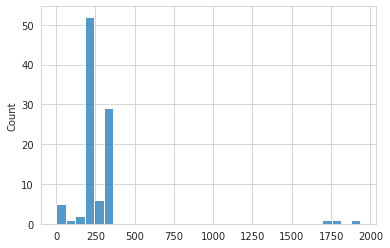

In [238]:
l = []
for i in nl_containers:
    l.append(i.size)
sns.histplot(l)

In [27]:
b = {'numpy': '1.15.2', 'pandas': '0.23.0', 'matplotlib': '3.0.0', 'ipywidgets': '7.2.1', 'ipython': '6.4.0'}

In [28]:
{k: b[k] for k in dep_list if k in b}

{'matplotlib': '3.0.0',
 'numpy': '1.15.2',
 'pandas': '0.23.0',
 'ipywidgets': '7.2.1',
 'ipython': '6.4.0'}

<a name='results'></a>
## X. Results

<br>

In [61]:
def to_dataframe(l1, l2, hue):
    return pd.DataFrame(
    {'x': l1,
     'y': l2,
     'hue': hue
    })

def to_dataframe(l1, l2, l3, hue):
    return pd.DataFrame(
    {'x': l1,
     'y': l2,
     'z': l3,
     'hue': hue
    })

In [32]:
stopper

NameError: name 'stopper' is not defined

### How long to run:

In [594]:
def model_speeds(given, amount):
    for model in ["naive", "lru_c", "lru_i", "land"]:
        start = time.time()
        MODEL_nl(model, "timeit")
        end = time.time()
        time4one = (end - start) / 1500
    
        if given == "amount":
            print(str(amount) + " launches computed in: " + str(model))
            print("Time for 1000: " + str(time4one * 1000))
            print("Seconds: " + str(time4one * amount))
            print("Minutes: " + str(time4one * amount / 60))
            print("Hours: " + str(time4one * amount / 60 / 60))
            print("------------------------------------------------")
            
        if given == "time":
            print("Launches computed in " + str(amount) + " hours: " + str(model))
            print("Time for 1000: " + str(time4one * 1000))
            seconds = amount * 60 * 60
            print("Launches: " + str(seconds / time4one))
            print("------------------------------------------------")
        
model_speeds("amount", 2000000)

2000000 launches computed in: naive
Time for 1000: 1.2970762252807617
Seconds: 2594.1524505615234
Minutes: 43.23587417602539
Hours: 0.7205979029337565
------------------------------------------------
2000000 launches computed in: lru_c
Time for 1000: 0.47581895192464196
Seconds: 951.6379038492839
Minutes: 15.8606317308214
Hours: 0.26434386218035666
------------------------------------------------
2000000 launches computed in: lru_i
Time for 1000: 0.44972976048787433
Seconds: 899.4595209757487
Minutes: 14.990992016262478
Hours: 0.24984986693770797
------------------------------------------------
2000000 launches computed in: land
Time for 1000: 7.308777650197348
Seconds: 14617.555300394695
Minutes: 243.62592167324493
Hours: 4.0604320278874155
------------------------------------------------


### Optimization on two parameters, ct_size and cache_size

https://scipy-lectures.org/intro/scipy/auto_examples/plot_2d_minimization.html

Input: 2 Mutable factors, Output: 1 Immutable factor

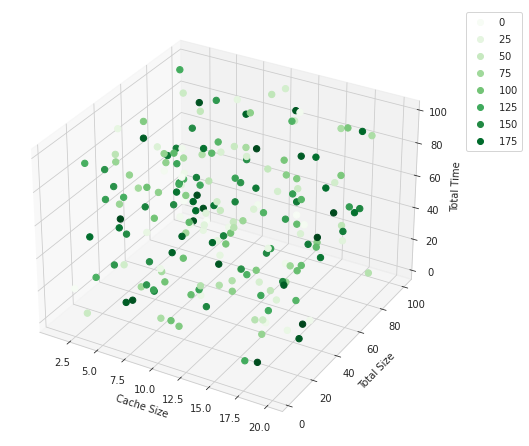

In [519]:
def scatter_3d(x=np.random.uniform(1, 20, size=200), y=np.random.uniform(1, 100, size=200),
              z=np.random.uniform(1, 100, size=200), hue=np.arange(200)):

    # axes instance
    fig = plt.figure(figsize=(6,6))
    ax = Axes3D(fig, auto_add_to_figure=False)
    fig.add_axes(ax)

    # get colormap from seaborn
    cmap = ListedColormap(sns.color_palette("Greens", 256).as_hex())

    # plot
    sc = ax.scatter(x, y, z, s=40, c=hue, marker='o', cmap=cmap, alpha=1)
    ax.set_xlabel('Cache Size')
    ax.set_ylabel('Total Size')
    ax.set_zlabel('Total Time')

    # legend
    plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)

scatter_3d()

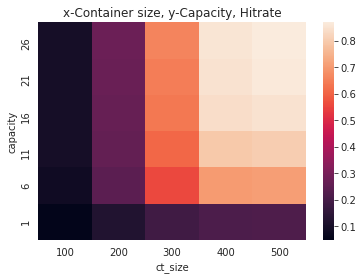

In [53]:
def visualize_2param_2D(model_type):
    ct_size, capacity, z_fact = [], [], []
    x_min, x_max, x_gap = 100, 600, 100
    y_min, y_max, y_gap = 1, 30, 5
    
    for i in np.arange(x_min, x_max, x_gap):
        for j in np.arange(y_min, y_max, y_gap):
            temp = MODEL_nl(model_type, "timeit", [i, -1, j])
            ct_size.append(i)
            capacity.append(j)
            z_fact.append(temp[6])
            
    data = pd.DataFrame(data={'ct_size': ct_size, 'capacity': capacity, 'hitrate': z_fact})
    data = data.pivot(columns='ct_size', index='capacity', values='hitrate')
    ax = sns.heatmap(data)
    sns.color_palette("Greens")
    ax.invert_yaxis()
    plt.title("x-Container size, y-Capacity, Hitrate")
    plt.show()
    
    return
        
    

visualize_2param_2D("lru_c")

Input: Mutable factor, Output: 2 Immutable factors

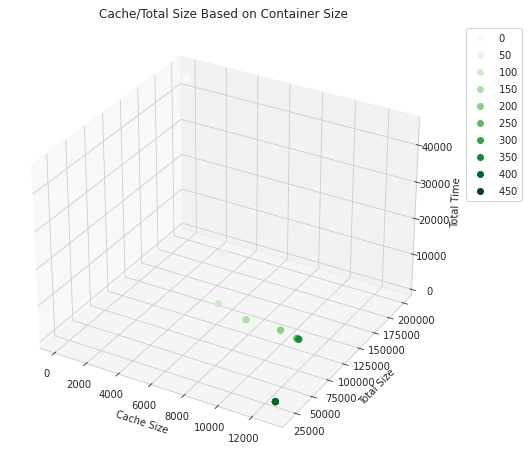

In [257]:
def RESULT_cc_sizes_basic_scatterplot(cap = False, plot_type = "2d"):
    cache_size, total_size, total_time, ct_size = [], [], [], []
    hitrate = []
    
    if cap:
        huerange = np.arange(0, 30, 5)
    else:
        huerange = np.arange(0, 500, 50)
    
    for i in huerange:
        if cap:
            temp = MODEL_nl("land", "timeit", [-1, -1, i], 0.5)
        else:
            temp = MODEL_nl("land", "timeit", [i, -1, -1], 0.5)
        total_size.append(temp[4])
        total_time.append(temp[5])
        cache_size.append(temp[7].get_total_size())
        hitrate.append(temp[6])
        ct_size.append(i)
    
    if plot_type == "3d":
        scatter_3d(cache_size, total_size, total_time, ct_size)
    elif plot_type == "2d":
        sns.scatterplot(x=cache_size, y=total_size, hue=ct_size)
        plt.xlabel("Cache Size")
        plt.ylabel("Total Size")
    elif plot_type == "pair":
        df_3d = pd.DataFrame(
            {'Cache Size': cache_size,
             'Total Size': total_size,
             'Total Time': total_time,
             'Container Size': ct_size,
             'Hitrate': hitrate
            })
        sns.pairplot(df_3d, hue='Container Size')
        
    
        
    
    if plot_type == "pair":
        pass
    elif cap:
        plt.title("Cache/Total Size Based on Capacity")
    else:
        plt.title("Cache/Total Size Based on Container Size")
    return
        
    
RESULT_cc_sizes_basic_scatterplot(False, "3d")

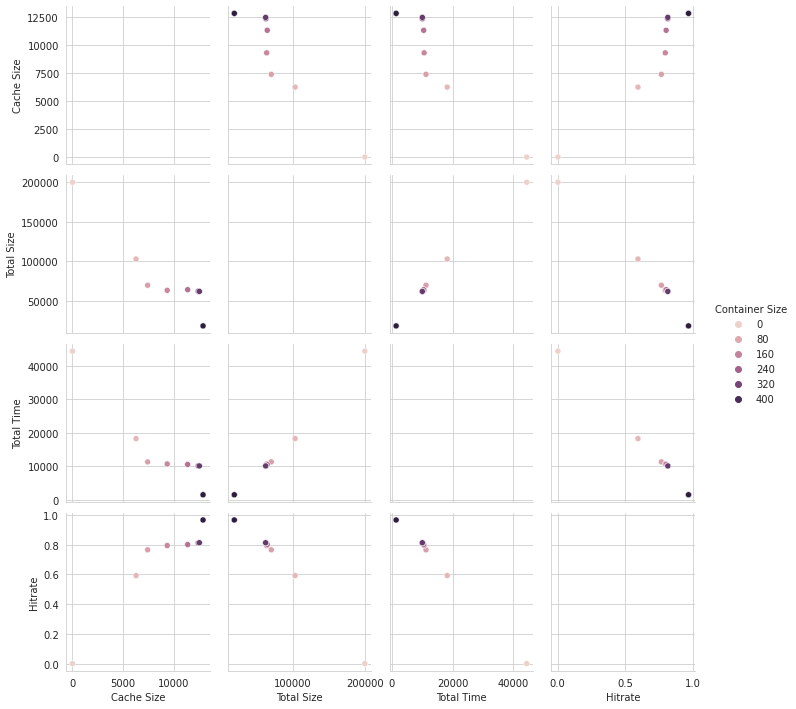

In [258]:
RESULT_cc_sizes_basic_scatterplot(False, "pair")

Attempts to combine capacity and container size as a single input, somehow.

In [ ]:
'''
def RESULT_cc_sizes_basic_scatterplot(threeD = False):
    cache_size, total_size, total_time, ct_size = [], [], [], []
    
    if cap:
        huerange = np.arange(0, 30, 5)
    else:
        huerange = np.arange(0, 400, 50)
    
    for i in huerange:
        if cap:
            temp = MODEL_nl("lru_c", "timeit", [-1, -1, i])
        else:
            temp = MODEL_nl("lru_c", "timeit", [i, -1, -1])
        total_size.append(temp[4])
        total_time.append(temp[5])
        cache_size.append(temp[7].get_total_size())
        ct_size.append(i)
    
    if threeD:
        sns.scatterplot(x=cache_size, y=total_size, z=total_time, hue=ct_size)
        plt.zlabel("Total Time")
    else:
        sns.scatterplot(x=cache_size, y=total_size, hue=ct_size)
        
    plt.xlabel("Cache Size")
    plt.ylabel("Total Size")
    
    if cap:
        plt.title("Cache/Total Size Based on Capacity")
    else:
        plt.title("Cache/Total Size Based on Container Size")
    return
        
    
RESULT_cc_sizes_basic_scatterplot(False, True)
'''

### Basic: Infinite capacity and container size. Finds total size and time.

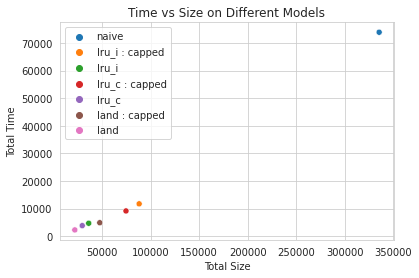

In [596]:
def RESULT_size_time_scatterplot(version):

    sizes, times, names = [], [], []
    
    for i in ["naive", "lru_i", "lru_c", "land"]:
        if i != "naive":
            temp = MODEL_nl(i, "timeit", [400, -1, 20], version)
            sizes.append(temp[4])
            times.append(temp[5])
            names.append(i + " : capped")
            
        temp = MODEL_nl(i, "timeit", [-1, -1, -1], version)
        sizes.append(temp[4])
        times.append(temp[5])
        names.append(i)
        
    sns.scatterplot(x=sizes, y=times, hue=names)
    plt.xlabel("Total Size")
    plt.ylabel("Total Time")
    plt.title("Time vs Size on Different Models")
    return
        
    
RESULT_size_time_scatterplot(False)

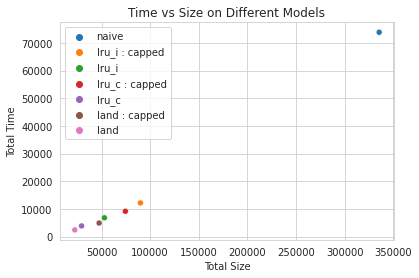

In [597]:
RESULT_size_time_scatterplot(True)

### LANDLORD

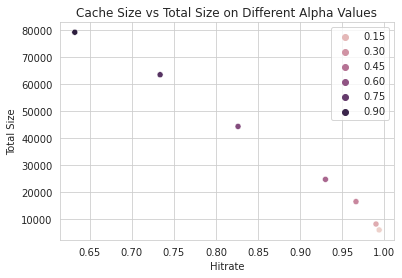

In [523]:
def RESULT_land_alpha_scatterplot():

    csize, tsize, names = [], [], []
    
    for i in np.arange(0.05, 1, 0.15):
        temp = MODEL_nl("land", "timeit", [400, -1, 5], False, i)
        #csize.append(temp[7].get_total_size())
        csize.append(temp[6])
        tsize.append(temp[4])
        names.append(i)
        
    sns.scatterplot(x=csize, y=tsize, hue=names)
    plt.xlabel("Hitrate")
    plt.ylabel("Total Size")
    plt.title("Cache Size vs Total Size on Different Alpha Values")
    return
        
    
RESULT_land_alpha_scatterplot()

### Full Model Runs

Return format:
 - 0: container size (constraint)
 - 1: capacity (constraint)
 - 2: total size overall
 - 3: total installation time overall
 - 4: hitrate
 - 5: total size of cache
 - 6: model name

In [648]:
def RESULT_model_nl(version, constraints, alpha):

    total_size, total_time, hitrate, cache_size, names = [], [], [], [], []
    
    for model in ["naive", "lru_i", "lru_c", "land"]:
        
        temp = MODEL_nl(model, "big", constraints, version, alpha)
        
        total_size.append(temp[4])
        total_time.append(temp[5])
        hitrate.append(temp[6])
        cache_size.append(temp[7].get_total_size())
        
        names.append(model)

    return constraints[0], constraints[2], total_size, total_time, hitrate, cache_size, names

In [ ]:
a = RESULT_model_nl(True, [-1, -1, -1], 0.7)
a

In [ ]:
b = RESULT_model_nl(False, [-1, -1, -1], 0.7)
b